In [1]:
import pandas as pd
import numpy as np
import torch 
%matplotlib inline
import math
import scipy.stats
import time
import torch.utils.data as Data
import torch.nn as nn
from sklearn.metrics import mean_squared_error,mean_absolute_error
import torch.nn.functional as F
from torch.optim import SGD
import matplotlib.pyplot as plt

In [2]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [3]:
train=pd.read_feather('J:quant_trade/trains.feather')
test=pd.read_feather('J:/quant_trade/tests.feather')
tlist=train.columns.tolist()
tlist=tlist[4:104]

In [4]:
x_train=train[tlist]
y_train=train['1W']
x_test=test[tlist]
y_test=test['1W']

In [7]:
train_xt=torch.from_numpy(x_train.values.astype(np.float32)).cuda()
train_yt=torch.from_numpy(y_train.values.astype(np.float32)).cuda()
test_xt=torch.from_numpy(x_test.values.astype(np.float32)).cuda()
test_yt=torch.from_numpy(y_test.values.astype(np.float32)).cpu()

In [8]:
train=None
test=None
x_train=None
y_train=None
x_test=None
y_test=None

In [9]:
train_data=Data.TensorDataset(train_xt,train_yt)
test_data=Data.TensorDataset(test_xt,test_yt)

In [14]:
class MLPrg(nn.Module):
    def __init__(self):
        super(MLPrg,self).__init__()
        self.hidden1=nn.Linear(in_features=100,out_features=1024,bias=True)
        self.predict=nn.Linear(1024,1)
        self.drop=nn.Dropout(0.2)
    def forward(self,x):
        x=F.tanh(self.hidden1(x))
        x=self.drop(x)
        output=self.predict(x)
        return output[:,0]
rg=MLPrg()
rg=rg.cuda()
loss_func=F.()
loss_func=loss_func.cuda()
train_loss_all=[]
maslist=[]
plt.figure(figsize=(10,6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [15]:
train_loader=Data.DataLoader(dataset=train_data,batch_size=256,shuffle=True,num_workers=0)
for step,(b_x,b_y) in enumerate(train_loader):
    if step>0:
        break

In [16]:
optimizer=torch.optim.Adam(rg.parameters(),lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [22]:
info=[]

0


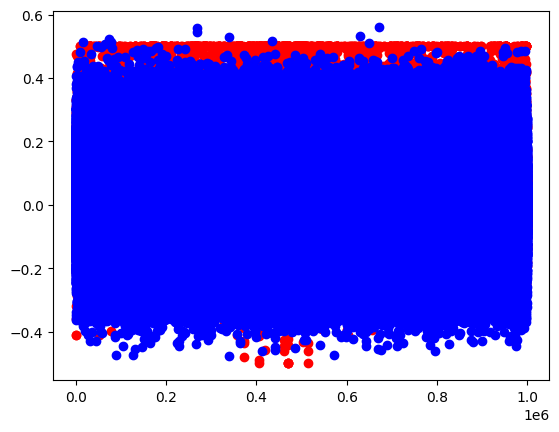

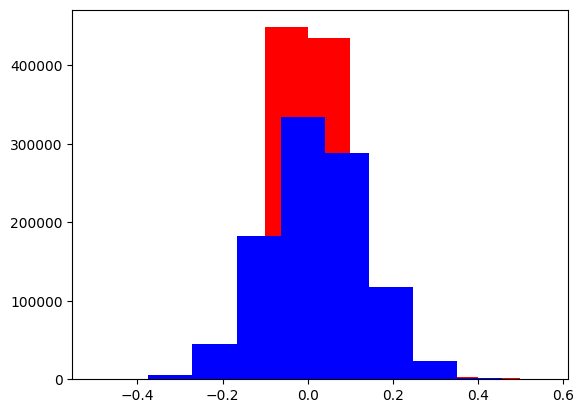

1


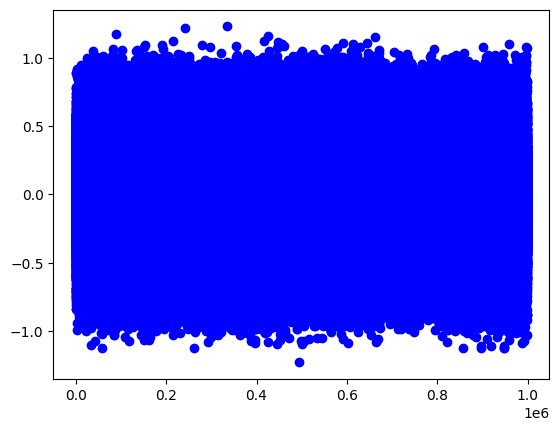

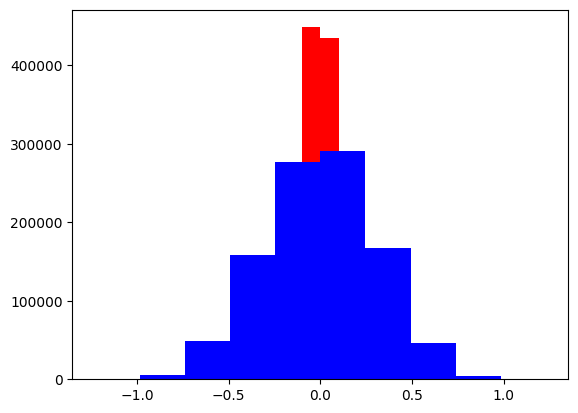

2


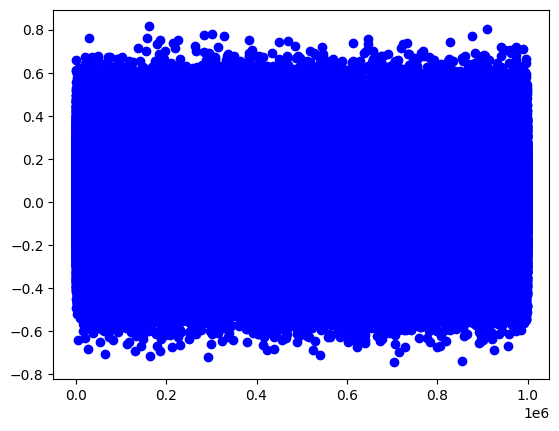

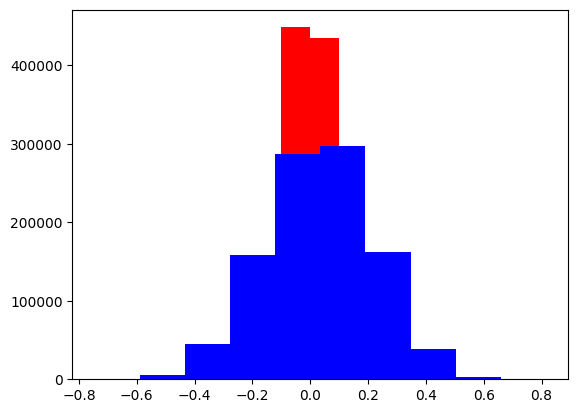

3


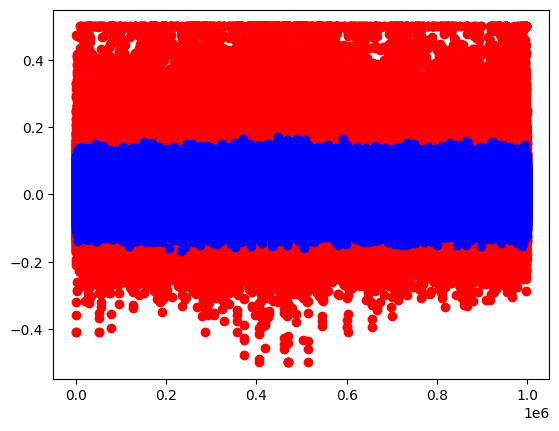

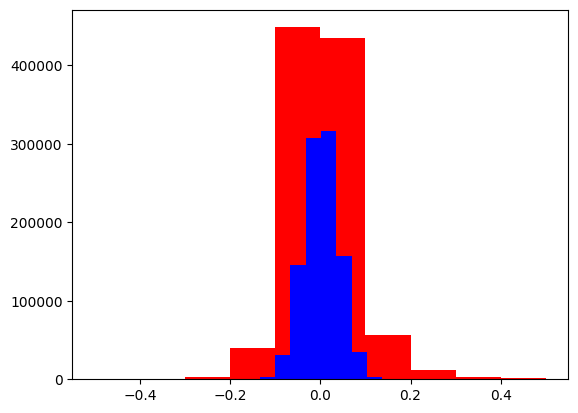

4


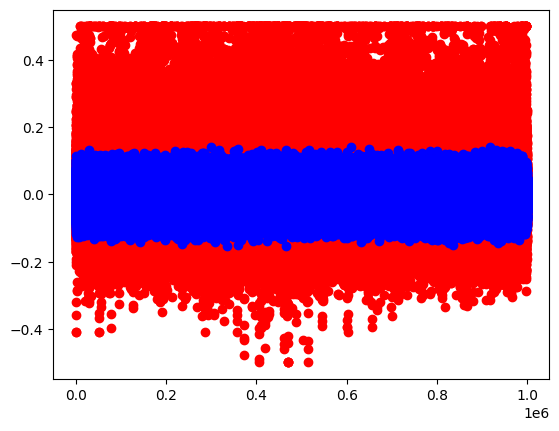

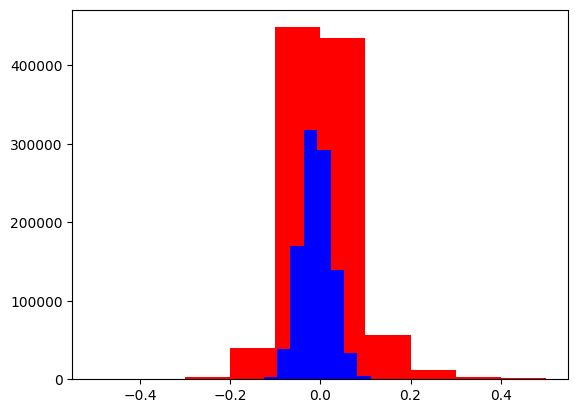

5


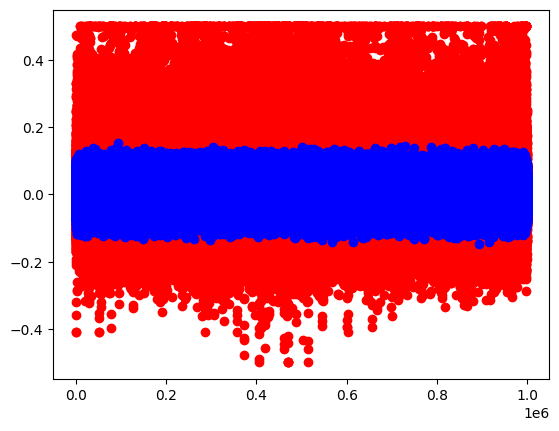

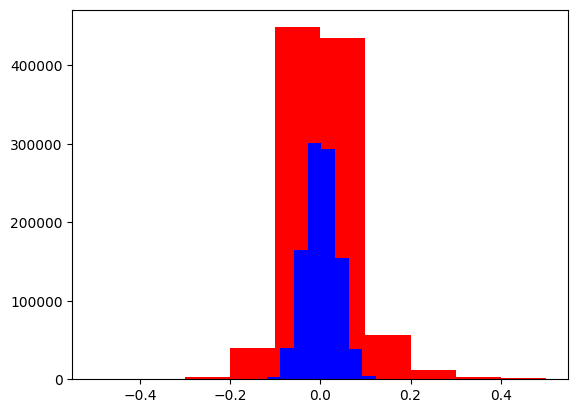

6


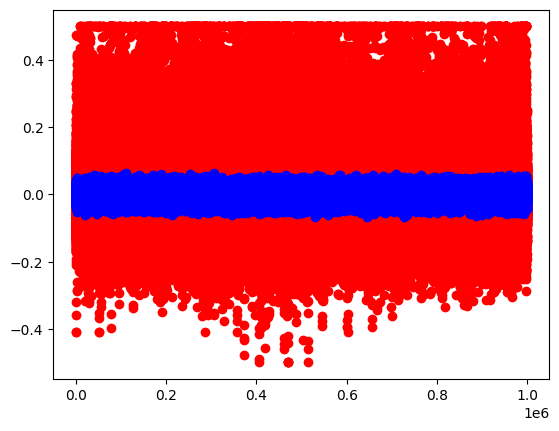

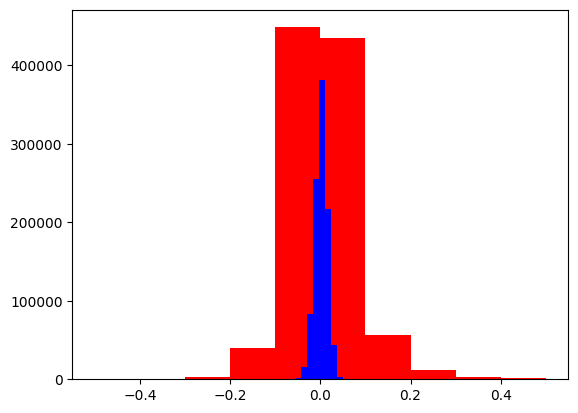

7


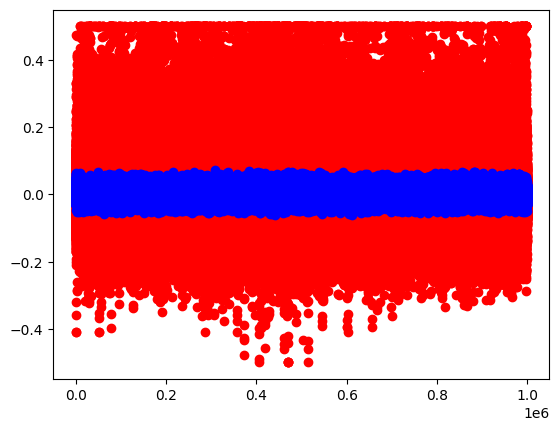

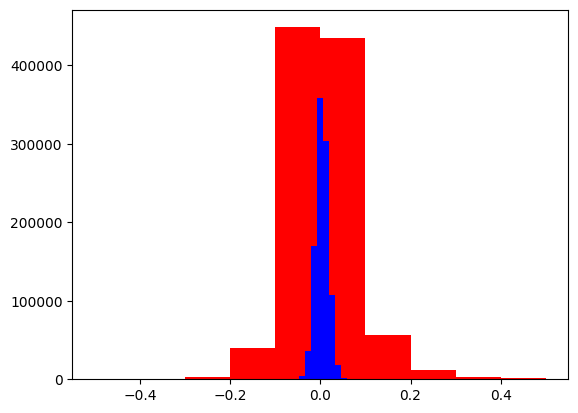

8


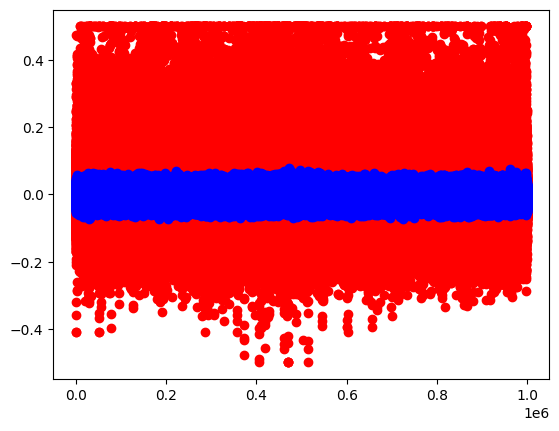

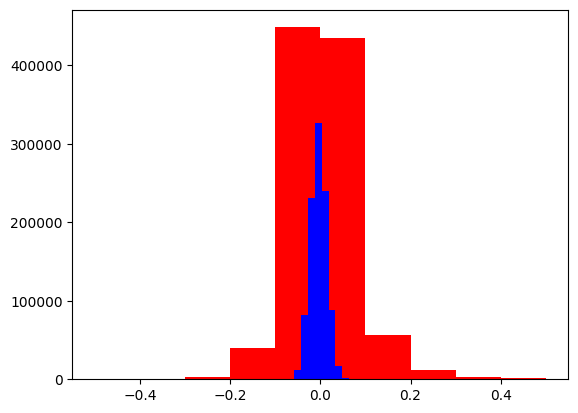

9


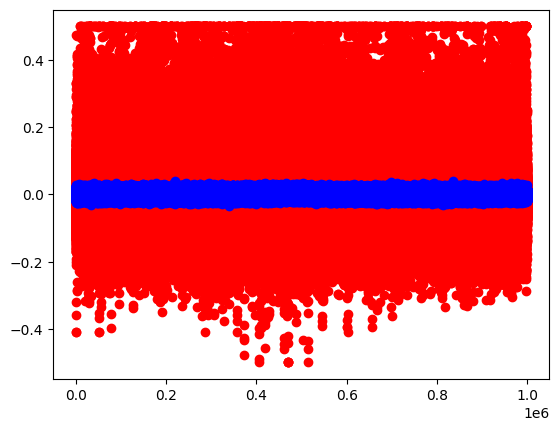

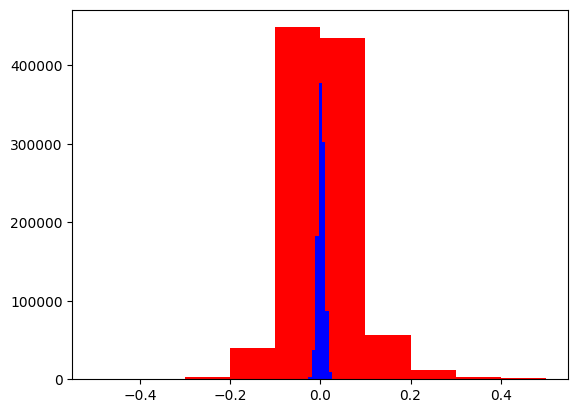

10


KeyboardInterrupt: 

In [23]:
minks=9999
timer = Timer()
for epoch in range(100):
    train_loss=0
    train_num=0
    print(epoch)
    for step,(b_x,b_y) in enumerate(train_loader):
        b_x=b_x.cuda()
        b_y=b_y.cuda()
        output=rg(b_x)
        loss=loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*b_x.size(0)
        train_num+=b_x.size(0)
    scheduler.step()
    train_loss_all.append(train_loss/train_num)
    testy=rg(test_xt)
    testy=testy.cpu()
    mae=mean_absolute_error(test_yt.detach().numpy(),testy.detach().numpy())
    df=pd.DataFrame()
    df['real']=test_yt
    df['pre']=testy.detach().numpy()
    idx=scipy.stats.ks_2samp(df['pre'],df['real'])
    ks=scipy.stats.ks_2samp(df['pre'],df['real'])[0]
    minks=min(minks,ks)
    if minks==ks:
        torch.save(rg,'J:/quant_trade/modelbase/bestks.pt')
    plt.scatter(y=df['real'],x=range(df.shape[0]),color='red')
    plt.scatter(y=df['pre'],x=range(df.shape[0]),color='blue')
    plt.show()
    plt.close()
    plt.hist(df['real'],color='red')
    plt.hist(df['pre'],color='blue')
    plt.show()
    plt.close()
    info.append([str(epoch),train_loss/train_num,mae,timer.stop(),ks,idx])
    pd.DataFrame(info).to_html('data.html')

In [15]:
torch.save(rg,'J:/quant_trade/modelbase/df2.pt')

In [16]:
train_loss_all

[27.002635648406475,
 18.544140664545562,
 0.009276392555576062,
 0.0074153927009412484,
 0.0074174981060414445,
 0.007416655795499432,
 0.007415930240528676,
 0.007418272285642802,
 0.0074154838065731464,
 0.007416872344939628,
 0.007412305649686937,
 0.007414258081914977,
 0.007416127329286041,
 0.007297979445267146,
 0.007298764941198353,
 0.007298657807332342,
 0.007280467190366789,
 0.007280457529860488,
 0.007280377937488645,
 0.007278199128669101,
 0.007278198344202879,
 0.007278200248441877]

In [17]:
print(min(train_loss_all))
print(min(maslist))

0.007278198344202879
0.050673004


In [19]:
now=pd.read_feather('J:/quant_trade/now.feather')
now_x=now[tlist]
now_y=now['1W']
now_x=scale.fit_transform(now_x)
xnow=torch.from_numpy(now_x.astype(np.float32)).cuda()
nowpy=rg(xnow)
nowpy=nowpy.cpu()
mae=mean_absolute_error(nowpy.detach().numpy(),now_y)
print(mae)

0.03806005285785802


In [20]:
pre=pd.read_feather('J:/quant_trade/pre.feather')
temp=pre.loc[pre['ts_code']=='600552']
temp_x=temp[tlist]
temp_y=temp['1W']
temp_x=scale.fit_transform(temp_x)
tempx=torch.from_numpy(temp_x.astype(np.float32)).cuda()
pretemp=rg(tempx)
pretemp=pretemp.cpu()
mae=mean_absolute_error(pretemp.detach().numpy(),temp_y)
print(mae)

2.6839054952304693


In [21]:
df=pd.DataFrame()
df['time']=temp['trade_date']
df['real']=temp_y
df['pre']=pretemp.detach().numpy()
df.set_index('time',inplace=True)
df['idx']=df['real']*df['pre']
df[df['idx']>0].shape[0]/df.shape[0]

0.5058823529411764

In [ ]:
df.plot()